In [ ]:
#Mounting the google drive
from google.colab import drive
drive.mount("/content/drive")

#File path for my files: /content/drive/MyDrive/tSNE


Mounted at /content/drive


In [ ]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

# Prepare

%matplotlib notebook

import numpy as np
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import pylab as plt
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import psutil
import time

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
#from fast_tsne import fast_tsne #I will probably use the scikit t-SNE instead to avoid installing FFTW


In [ ]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

#Loading the data
#Replaced .. in file paths with /content/drive/MyDrive/tSNE
%%time

# Load the Allen institute data. This takes a few minutes

# This function is needed because using Pandas to load these files in one go
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size

        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk2.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['/content/drive/MyDrive/tSNE/data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv',
             '/content/drive/MyDrive/tSNE/data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('/content/drive/MyDrive/tSNE/data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('/content/drive/MyDrive/tSNE/data/tasic-nature/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas,
             'clusterColors': clusterColors, 'clusterNames': clusterNames}
counts = []
memory_usage = psutil.virtual_memory()
print(f"Memory Usage: {memory_usage}")

.............................................. done
Memory Usage: svmem(total=13613314048, available=2989842432, percent=78.0, used=10308276224, free=175759360, active=839221248, inactive=12326338560, buffers=322621440, cached=2806657024, shared=2703360, slab=173080576)%
CPU times: user 4min 51s, sys: 21.4 s, total: 5min 12s
Wall time: 5min 30s


In [ ]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
print('Number of cells:', tasic2018['counts'].shape[0])
print('Number of cells from ALM:', np.sum(tasic2018['areas']==0))
print('Number of cells from VISp:', np.sum(tasic2018['areas']==1))
print('Number of clusters:', np.unique(tasic2018['clusters']).size)
print('Number of genes:', tasic2018['counts'].shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(
    tasic2018['counts'].size/np.prod(tasic2018['counts'].shape)))

#Number of cells from ALM is 15413 vs 9573 in the github
#Number of cells from VISp is 10068 vs 14249 in the github

Number of cells: 23822
Number of cells from ALM: 15413
Number of cells from VISp: 10068
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


In [ ]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
#Pre-processing:

%%time

# Feature selection

def nearZeroRate(data, threshold=0):
    zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
    return zeroRate

def meanLogExpression(data, threshold=0, atleast=10):
    nonZeros = np.squeeze(np.array((data>threshold).sum(axis=0)))
    N = data.shape[0]
    A = data.multiply(data>threshold)
    A.data = np.log2(A.data)
    meanExpr = np.zeros(data.shape[1]) * np.nan
    detected = nonZeros >= atleast
    meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (nonZeros[detected]/N)
    return meanExpr

def featureSelection(meanLogExpression, nearZeroRate, yoffset=.02, decay=1.5, n=3000):
    low = 0; up=10
    nonan = ~np.isnan(meanLogExpression)
    xoffset = 5
    for step in range(100):
        selected = np.zeros_like(nearZeroRate).astype(bool)
        selected[nonan] = nearZeroRate[nonan] > np.exp(-decay*meanLogExpression[nonan] + xoffset) + yoffset
        if np.sum(selected) == n:
            break
        elif np.sum(selected) < n:
            up = xoffset
            xoffset = (xoffset + low)/2
        else:
            low = xoffset
            xoffset = (xoffset + up)/2
    return selected

x = meanLogExpression(tasic2018['counts'], threshold=32)  # Get mean log non-zero expression of each gene
y = nearZeroRate(tasic2018['counts'], threshold=32)       # Get near-zero frequency of each gene
selectedGenes = featureSelection(x, y, n=3000)            # Adjust the threshold to select 3000 genes

memory_usage2 = psutil.virtual_memory()
print(f"Memory Usage: {memory_usage2}")

Memory Usage: svmem(total=13613314048, available=8184446976, percent=39.9, used=5113761792, free=6669275136, active=840617984, inactive=5813690368, buffers=307314688, cached=1522962432, shared=2732032, slab=172756992)
CPU times: user 49.5 s, sys: 14.7 s, total: 1min 4s
Wall time: 1min 6s


In [ ]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

#Not quite sure what this is supposed to do.. I think PCA initialization?

%%time

counts3k = tasic2018['counts'][:, selectedGenes]  # Feature selection

librarySizes = tasic2018['counts'].sum(axis=1)    # Compute library sizes
CPM = counts3k / librarySizes * 1e+6              # Library size normalisation


logCPM = np.log2(CPM + 1)                         # Log-transformation
logCPM = np.asarray(logCPM)

model = PCA(n_components=50, svd_solver='full')

pca = model.fit(logCPM)  # PCA (TypeError occurs here because logCPM is not an array. Tried to use np.asarray( ) to convert it and IT WORKED!!!!)

flipSigns = np.sum(pca.components_, axis=1) < 0             # fix PC signs
X = pca.transform(logCPM)
X[:, flipSigns] *= -1

print('Shape of the resulting matrix:', X.shape, '\n')


#Principal component analysis
memory_usage3 = psutil.virtual_memory()
print(f"Memory Usage: {memory_usage3}")

Shape of the resulting matrix: (23822, 50) 

Memory Usage: svmem(total=13613314048, available=7004864512, percent=48.5, used=6293377024, free=5473042432, active=842530816, inactive=7019048960, buffers=308731904, cached=1538162688, shared=2752512, slab=172613632)
CPU times: user 2min 34s, sys: 9.94 s, total: 2min 44s
Wall time: 1min 47s


In [ ]:
#https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/

from sklearn import manifold
import os, time
import gzip

#import matplotlib.pyplot as plt
import seaborn as sns
color= sns.color_palette()
import matplotlib as mpl

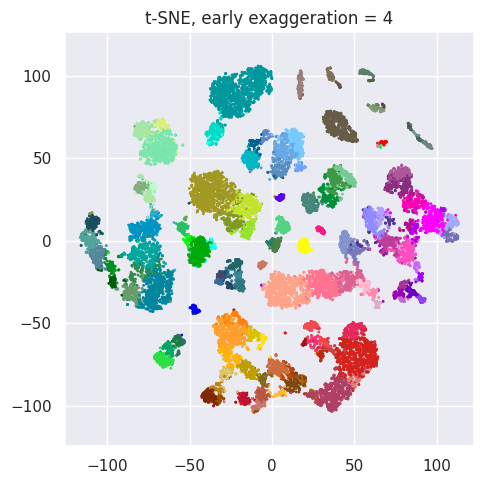

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

#Trying to run t-SNE on the PCA initialized data

z = sklearn.manifold.TSNE(n_components=2,
                      perplexity=30.0,
                      early_exaggeration=4.0,
                      learning_rate='auto',
                      n_iter=1000,
                      n_iter_without_progress=300,
                      min_grad_norm=1e-07,
                      metric='euclidean',
                      metric_params=None,
                      init='pca',
                      verbose=0,
                      random_state=None,
                      method='barnes_hut',
                      angle=0.5,
                      n_jobs=None).fit_transform(X)

#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
%matplotlib inline

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(z[:,0], z[:,1], s=1,
            color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('t-SNE, early exaggeration = 4')
plt.tight_layout()
plt.show()

memory_usage4 = psutil.virtual_memory()

In [ ]:
print(f"Memory Usage: {memory_usage4}")

Memory Usage: svmem(total=13613314048, available=7015776256, percent=48.5, used=6282285056, free=5456998400, active=845942784, inactive=6993784832, buffers=310910976, cached=1563119616, shared=2850816, slab=172695552)


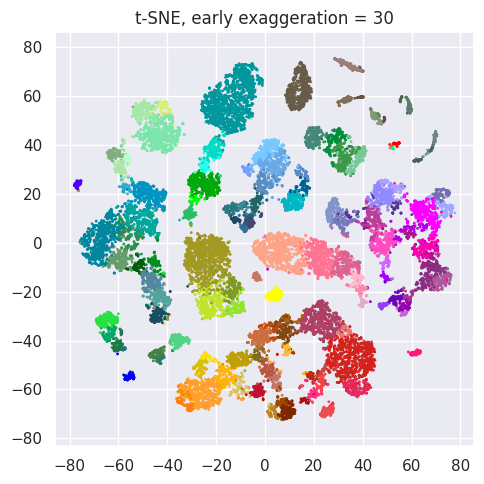

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

#Trying to run t-SNE on the PCA initialized data

z = sklearn.manifold.TSNE(n_components=2,
                      perplexity=30.0,
                      early_exaggeration=30.0,
                      learning_rate='auto',
                      n_iter=1000,
                      n_iter_without_progress=300,
                      min_grad_norm=1e-07,
                      metric='euclidean',
                      metric_params=None,
                      init='pca',
                      verbose=0,
                      random_state=None,
                      method='barnes_hut',
                      angle=0.5,
                      n_jobs=None).fit_transform(X)

#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
%matplotlib inline

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(z[:,0], z[:,1], s=1,
            color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('t-SNE, early exaggeration = 30')
plt.tight_layout()
plt.show()

memory_usage5 = psutil.virtual_memory()

In [ ]:
print(f"Memory Usage: {memory_usage5}")

Memory Usage: svmem(total=13613314048, available=6913642496, percent=49.2, used=6384685056, free=5613191168, active=767303680, inactive=6922801152, buffers=303804416, cached=1311633408, shared=2875392, slab=172101632)


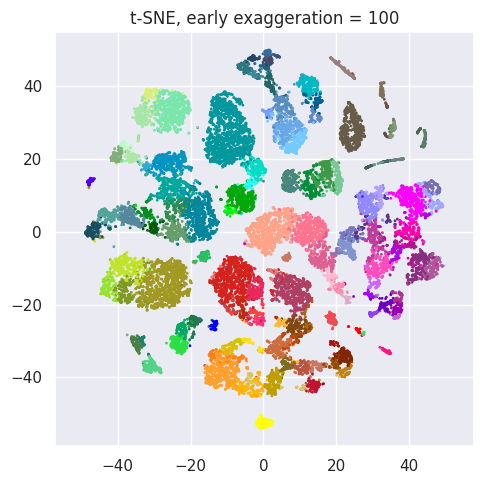

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

#Trying to run t-SNE on the PCA initialized data

z = sklearn.manifold.TSNE(n_components=2,
                      perplexity=30.0,
                      early_exaggeration=100.0,
                      learning_rate='auto',
                      n_iter=1000,
                      n_iter_without_progress=300,
                      min_grad_norm=1e-07,
                      metric='euclidean',
                      metric_params=None,
                      init='pca',
                      verbose=0,
                      random_state=None,
                      method='barnes_hut',
                      angle=0.5,
                      n_jobs=None).fit_transform(X)
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
%matplotlib inline

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(z[:,0], z[:,1], s=1,
            color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('t-SNE, early exaggeration = 100')
plt.tight_layout()
plt.show()

memory_usage6 = psutil.virtual_memory()

In [ ]:
print(f"Memory Usage: {memory_usage6}")

Memory Usage: svmem(total=13613314048, available=6956515328, percent=48.9, used=6341771264, free=5649293312, active=770277376, inactive=6849716224, buffers=305274880, cached=1316974592, shared=2895872, slab=172101632)
